# Dualなネットワークにおける検索
- このnotebookではVisNet(2017)のVGGと浅いネットワークを並列に組むというモデルを試したもの。
- 入力がシングルの場合と若干異なるので別にnotebookを用意した。
#### 2019/10/11
- Improved Triplet Loss(dense_num=100)のモデルを実行
#### 2019/10/30
- Improbed Triplet loss(dense_num=150)を利用しても精度が上がらない(Tシャツカテゴリ)
- コードのミスの可能性？
#### 2019/11/17
- 初歩的なコードミスであることが判明
- Improved Triplet Lossの中身で-を+にしていた

In [1]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import os
BASE_PATH = './dataset/T_Shirt_all/'

### RTXを載せたUbuntuでCNN実行するとUnknown Errorになる。
- 下記コードにより回避

In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### modelの用意

In [5]:
from keras.models import load_model
model_epoch = 120
ALPHA=0.1
BETA=0.05
dense_num = 150
# embedding設定に使う
vec_length=dense_num*2

## singleの場合
# con_embNet = load_model('./model/T_Shirt/krasser/con_emb_e{}.h5'.format(model_epoch))
# shop_embNet = load_model('./model/T_Shirt/krasser/shop_emb_e{}.h5'.format(model_epoch))

# Dualなネットワーク 
con_embNet = load_model('./model/T_Shirt/improved_tripletloss/a{}b{}_sub/con_emb{}_e{}.h5'.format(ALPHA,BETA,dense_num,model_epoch), compile=False)
shop_embNet = load_model('./model/T_Shirt/improved_tripletloss/a{}b{}_sub/shop_emb{}_e{}.h5'.format(ALPHA,BETA,dense_num,model_epoch), compile=False)

Instructions for updating:
Colocations handled automatically by placer.


### 既に分割したtestデータを呼んでくる

In [6]:
f = open("./test_ids.txt","rb")
test_ids = pickle.load(f)

In [7]:
test_ids[:5]

['id_00010696', 'id_00023825', 'id_00017789', 'id_00022720', 'id_00003304']

In [8]:
# 自作moduleのimport
import datagen

In [9]:
test_pairs = datagen.get_test_pairs(test_ids,BASE_PATH,seed_num=0)

100%|██████████| 2032/2032 [00:00<00:00, 2588.33it/s]


In [10]:
test_pairs[0]

[10696,
 ['./dataset/T_Shirt_all/id_00010696/comsumer_01.jpg',
  './dataset/T_Shirt_all/id_00010696/shop_01.jpg']]

In [11]:
print("test_pairsの中身 : [product_id,['con_path','shop_path']] \ntest_pairs[0] : %s" %test_pairs[0])

test_pairsの中身 : [product_id,['con_path','shop_path']] 
test_pairs[0] : [10696, ['./dataset/T_Shirt_all/id_00010696/comsumer_01.jpg', './dataset/T_Shirt_all/id_00010696/shop_01.jpg']]


In [12]:
test_pairs[0][1][1]

'./dataset/T_Shirt_all/id_00010696/shop_01.jpg'

In [13]:
import pickle
f = open('test_pairs.txt', 'wb')
pickle.dump(test_pairs, f)

### 検索画像プール(gallery)作成
- idをintに直す必要がある?gallery=[id(string),[np.ndarray]]にしたらどう？
- とりあえずtestだけのgalleryでやってみよう

In [14]:
aaa =[['id_0000000',np.zeros(10)] ,['id_0000001',np.ones(10)]]
aaa

[['id_0000000', array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 ['id_0000001', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]]

In [15]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])
gallery[0]

[10696, './dataset/T_Shirt_all/id_00010696/shop_01.jpg']

In [16]:
len(gallery)

2032

ギャラリー（検索対象）画像をベクトルの形に埋め込んでいく

In [17]:
vec_length=300
# 予め入れ物を用意or後でappend
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
# gallery=[id,img_path]
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
#     emb_vecs[i] = shop_embNet.predict(np.expand_dims([img,img],axis=0))[0] # need [0] because of expanding dimension -> [[]]
    emb_vecs[i] = shop_embNet.predict([np.expand_dims(img,axis=0),np.expand_dims(img,axis=0)])[0] # need [0] because of expanding dimension -> [[]]

100%|██████████| 2032/2032 [00:33<00:00, 61.47it/s]


ユークリッド距離を計算する関数distance

In [19]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [20]:
query_ids = np.zeros(len(test_pairs))
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
    
query_ids[:5]

array([10696., 23825., 17789., 22720.,  3304.])

- ~~idxsのところ実装ミスの可能性~~<br>
- N=50として予めtopN_id_listを作成しておけばスライスによって任意のtopKを算出できる

In [21]:
# N = 20

# topN_id_list=[] # [[query1->上位20個のid],...,[queryK->上位20個のid]]
# for tp in test_pairs:
#     img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
#     test = shop_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]
# #     test = con_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]

#     # calc order
#     similarities = np.zeros(len(emb_vecs))
#     for i,emb_vec in enumerate(emb_vecs):
#         similarities[i] = distance(test,emb_vec) # retrieve from all the images
#     idxs = similarities.argsort() # ascending order/ argsort() returns indexes
#     topN_id_list.append(ans_ids[idxs[:N]]) # append ids

In [22]:
N = 50

topN_id_list=[] # [[query1->上位20個のid],...,[queryK->上位20個のid]]
for tp in tqdm(test_pairs):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    test = shop_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0),np.expand_dims(img.astype(np.float32),axis=0)])[0]
#     test = con_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]

    # calc order
    similarities = np.zeros(len(emb_vecs))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = distance(test,emb_vec) # retrieve from all the images
    idxs = similarities.argsort() # ascending order/ argsort() returns indexes
    topN_id_list.append(ans_ids[idxs[:N]]) # append ids

100%|██████████| 2032/2032 [01:03<00:00, 32.49it/s]


In [23]:
topN_id_list[0]

array([27011.,  5295., 33292., 11298., 32446.,  5552., 18096., 16088.,
       16968., 18285., 19975., 19359.,  8050., 16631.,  8232., 25218.,
       14523., 23763., 15841., 25572., 28681., 20948., 21328., 20831.,
       19495., 25514.,  9782., 22968.,  4573., 21740., 28985., 17806.,
       29917., 26248., 30769., 21701., 15885., 17408., 25926., 25383.,
       11530., 24142., 20748.,  9403.,  4835., 13608., 12078.,  4837.,
       20825., 19365.])

cf. bench mark(FashionNet): 0.18

In [24]:
lim = 5
#lim=50
cnt = 0
top20_ids = []
topN_ids = []
topN_idxs = []
for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
    if ans_id in topN_id[:lim]:
        cnt+=1
        topN_ids.append(ans_id)
        topN_idxs.append(i)
    if ans_id in topN_id[:20]:
#         top20_ids.append(i)
        top20_ids.append(ans_id)
#         print(ans_id)
print("{0}-top:{1}".format(lim,cnt/len(test_ids)))
# print(top20_ids)

5-top:0.10088582677165354


In [25]:
type(topN_idxs)

list

In [26]:
def calc_topk_vals(k_values,ans_ids,topN_id_list,length):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/length)
    return topk_vals

In [27]:
x=[1,5,10,20,30,40,50]
mynet=calc_topk_vals(x,ans_ids,topN_id_list,len(test_ids))

In [28]:
mynet

[0.03543307086614173,
 0.10088582677165354,
 0.14763779527559054,
 0.20127952755905512,
 0.2485236220472441,
 0.28937007874015747,
 0.3233267716535433]

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'top-k acc')

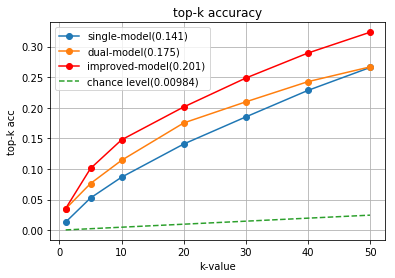

In [29]:
x=[1,5,10,20,30,40,50]
# fashionNet=[0.07,0.12,0.15,0.188,0.21,0.22,0.225]
premodel=[0.01328740157480315,
 0.05265748031496063,
 0.08661417322834646,
 0.140748031496063,
 0.18503937007874016,
 0.2283464566929134,
 0.265748031496063]
dual_simple=[0.034940944881889764,
 0.07627952755905512,
 0.1141732283464567,
 0.17519685039370078,
 0.20964566929133857,
 0.24261811023622049,
 0.26673228346456695]
mynet=calc_topk_vals(x,ans_ids,topN_id_list,len(test_ids))
chancelv=np.array(x)/len(test_pairs)

# plt.plot(x,fashionNet,marker='o',label='FashionNet(0.188)')
plt.plot(x,premodel,marker='o',label='single-model(0.141)')
plt.plot(x,dual_simple,marker='o',label='dual-model(0.175)')
plt.plot(x,mynet,c='r',marker='o',label='improved-model({})'.format(round(mynet[3],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")

# plt.savefig('./result_img/result_epoch{}.png'.format(model_epoch))
# plt.savefig('./improveda0.1b0.02_result_epoch{}.png'.format(model_epoch),dpi=300)

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

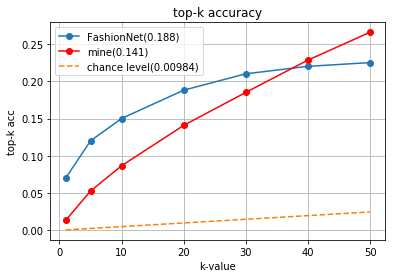

In [330]:
x=[1,5,10,20,30,40,50]
fashionNet=[0.07,0.12,0.15,0.188,0.21,0.22,0.225]
# mynet=[0.011,0.0325,0.055,0.0885,0.11958,0.147,0.166]
mynet=calc_topk_vals(x,ans_ids,topN_id_list,len(test_ids))
chancelv=np.array(x)/len(test_pairs)

plt.plot(x,fashionNet,marker='o',label='FashionNet(0.188)')
plt.plot(x,mynet,c='r',marker='o',label='mine({})'.format(round(mynet[3],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')
plt.legend(loc='upper left')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")

plt.savefig('./result_img/result_epoch{}.png'.format(model_epoch))

予測するときにresizeしているだけで元の画像を(128,128)にしているわけではないので比率を保って表示できる。

queryと結果のidが同じときに枠線の色を変えたい

In [26]:
len(topN_idxs)

155

### ★Dualでのみtop5に入っているidを利用する場合

In [31]:
# goodidx = np.array(topN_idxs[10:50]) #結果の良かったものをgoodidxとして取り出す
goodidx = np.array(topN_idxs) #結果の良かったものをgoodidxとして取り出す
print(goodidx)
# リストのスライスのため
from operator import itemgetter
results = itemgetter(*goodidx)(test_pairs) #goodidxのインデックスの要素を取り出す

[   5    9   31   34   57   95  105  106  117  126  127  199  207  216
  217  231  260  263  272  279  284  289  300  324  354  361  389  395
  426  453  535  551  569  598  604  609  626  643  651  653  669  721
  724  728  734  758  784  822  834  835  843  869  929  930  940  956
  974  976  999 1007 1030 1053 1084 1093 1119 1127 1130 1134 1159 1223
 1235 1237 1250 1343 1390 1394 1395 1424 1466 1488 1524 1527 1531 1548
 1552 1562 1579 1588 1609 1634 1670 1673 1686 1701 1704 1758 1782 1783
 1822 1839 1849 1899 1904 1908 1912 1941 1944 1948 1954 1960 2019 2029]


#### 手法間で訂正的な検索の評価を行うためリストをPickleで保存

In [30]:
import pickle
with open('dual_results.pickle', 'wb') as f:
    pickle.dump(results, f)

with open('dual_goodidx.pickle', 'wb') as f:
    pickle.dump(goodidx, f)

### ★シングルのネットワークで良い結果だったidも含める場合

In [24]:
f = open("./set_goodidx.pickle","rb")
goodidx = pickle.load(f)
print(goodidx)
# リストのスライスのため
from operator import itemgetter
results = itemgetter(*goodidx)(test_pairs) #goodidxのインデックスの要素を取り出す

{1030, 7, 9, 1548, 1042, 1557, 22, 534, 1560, 1562, 1053, 32, 39, 554, 43, 1068, 1070, 49, 1084, 62, 1601, 65, 69, 1093, 1101, 1104, 1105, 1109, 598, 1622, 89, 601, 91, 93, 1117, 1632, 609, 1634, 1125, 105, 1642, 1130, 1644, 1134, 622, 624, 1136, 1650, 117, 632, 1147, 1661, 638, 639, 646, 136, 1673, 651, 1676, 653, 1164, 1166, 145, 658, 664, 153, 668, 1696, 678, 1190, 680, 1196, 173, 1709, 687, 1711, 691, 1715, 182, 1207, 697, 1724, 700, 1222, 1735, 200, 1224, 199, 713, 1225, 1229, 721, 210, 211, 1235, 728, 734, 223, 1247, 1758, 741, 232, 752, 240, 753, 1782, 1783, 761, 1788, 257, 1795, 1798, 263, 267, 1293, 782, 270, 1296, 272, 1297, 279, 281, 284, 800, 289, 1830, 809, 299, 300, 1837, 1323, 822, 1847, 1848, 1336, 1851, 1343, 833, 834, 835, 324, 1348, 1860, 839, 1866, 1355, 333, 1870, 1877, 1365, 344, 346, 351, 1380, 1899, 876, 365, 1387, 881, 1395, 885, 1397, 1398, 376, 377, 1914, 1407, 383, 389, 395, 1421, 1938, 404, 1428, 1430, 1941, 1944, 409, 1945, 1439, 1952, 1954, 418, 423, 1960

In [33]:
def show_correct(img):
    try:
        img = np.array(img)
        img = np.array([np.pad(img[:,:,0], (8,8), 'constant', constant_values=(255,255)),np.pad(img[:,:,1], (8,8), 'constant',constant_values=(0,0)),np.pad(img[:,:,2], (8,8), 'constant',constant_values=(0,0))])
        plt.imshow(img.transpose(1,2,0))
    except:
        pass

## デュアル用の検索結果

In [1]:
imheight,imwidth=128,128
num = 5
for tp in results[:10]:
    # show query
    fig = plt.figure(figsize=(20,10))
    plt.subplot(1,6,1)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    raw_img = Image.open(tp[1][0])
    img =np.array(raw_img.resize((128,128)).convert('RGB'))/255.
    test = shop_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0),np.expand_dims(img.astype(np.float32),axis=0)])[0]
    plt.title('query_{}'.format(tp[0]),fontsize=18)
    show_correct(raw_img)

    # calc order(すでに計算済みなのでここは無駄かもしれない)
    similarities = np.zeros(len(emb_vecs))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = distance(test,emb_vec)
    idxs = similarities.argsort() #ascending order b.c. smaller is better/ get the index array in ascending order
    
    # show nearest
    plt.subplot(1,6,2)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    nearest = Image.open(gallery[idxs[0]][1])
    plt.title('1st',fontsize=18)
    if gallery[idxs[0]][0] == tp[0]:
        show_correct(nearest)
    else:
        plt.imshow(nearest)
    
    # show 2nd
    plt.subplot(1,6,3)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    second =  Image.open(gallery[idxs[1]][1])

    if gallery[idxs[1]][0] == tp[0]:
        show_correct(second)
    else:
        plt.imshow(second)
        
    plt.title('2nd',fontsize=18)
        
    
    # show 3rd
    plt.subplot(1,6,4)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    third =  Image.open(gallery[idxs[2]][1])
    plt.title('3rd',fontsize=18)
    if gallery[idxs[2]][0] == tp[0]:
        show_correct(third)
    else:
        plt.imshow(third)
    
    # show 4th
    plt.subplot(1,6,5)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    fourth =  Image.open(gallery[idxs[3]][1])
    plt.title('4th',fontsize=18)
    if gallery[idxs[3]][0] == tp[0]:
        show_correct(fourth)
    else:
        plt.imshow(fourth)
    
    
    # show 5th
    plt.subplot(1,6,6)
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
    fifth =  Image.open(gallery[idxs[4]][1])
    plt.title('5th',fontsize=18)
    if gallery[idxs[4]][0] == tp[0]:
        show_correct(fifth)
    else:
        plt.imshow(fifth)
    
# 保存が必要なときのみ下行のコメントアウトを外す。    
#     plt.savefig('./result_img/dual_model190604/{}_{}.png'.format(tp[0],model_epoch),bbox_inches="tight")

NameError: name 'results' is not defined

## シングル用の検索結果表示(コメントアウト外せば使える)

In [37]:
# imheight,imwidth=128,128
# num = 5
# for tp in results:
#     # show query
#     fig = plt.figure(figsize=(20,10))
#     plt.subplot(1,6,1)
#     plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
#     plt.tick_params(color='white')
#     raw_img = Image.open(tp[1][0])
#     img =np.array(raw_img.resize((128,128)).convert('RGB'))/255.
#     test = shop_embNet.predict(np.expand_dims(img.astype(np.float32),axis=0))[0]
#     plt.title('query',fontsize=18)
#     show_correct(raw_img)

#     # calc order
#     similarities = np.zeros(len(emb_vecs))
#     for i,emb_vec in enumerate(emb_vecs):
#         similarities[i] = distance(test,emb_vec)
#     idxs = similarities.argsort() #ascending order b.c. smaller is better/ get the index array in ascending order
    
#     # show nearest
#     plt.subplot(1,6,2)
#     plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
#     plt.tick_params(color='white')
#     nearest = Image.open(gallery[idxs[0]][1])
#     plt.title('1st',fontsize=18)
#     if gallery[idxs[0]][0] == tp[0]:
#         show_correct(nearest)
#     else:
#         plt.imshow(nearest)
    
#     # show 2nd
#     plt.subplot(1,6,3)
#     plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
#     plt.tick_params(color='white')
#     second =  Image.open(gallery[idxs[1]][1])

#     if gallery[idxs[1]][0] == tp[0]:
#         show_correct(second)
#     else:
#         plt.imshow(second)
        
#     plt.title('2nd',fontsize=18)
        
    
#     # show 3rd
#     plt.subplot(1,6,4)
#     plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
#     plt.tick_params(color='white')
#     third =  Image.open(gallery[idxs[2]][1])
#     plt.title('3rd',fontsize=18)
#     if gallery[idxs[2]][0] == tp[0]:
#         show_correct(third)
#     else:
#         plt.imshow(third)
    
#     # show 4th
#     plt.subplot(1,6,5)
#     plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
#     plt.tick_params(color='white')
#     fourth =  Image.open(gallery[idxs[3]][1])
#     plt.title('4th',fontsize=18)
#     if gallery[idxs[3]][0] == tp[0]:
#         show_correct(fourth)
#     else:
#         plt.imshow(fourth)
    
    
#         # show 5th
#     plt.subplot(1,6,6)
#     plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
#     plt.tick_params(color='white')
#     fifth =  Image.open(gallery[idxs[4]][1])
#     plt.title('5th',fontsize=18)
#     if gallery[idxs[4]][0] == tp[0]:
#         show_correct(fifth)
#     else:
#         plt.imshow(fifth)
    
# # 保存が必要なときのみ下行のコメントアウトを外す。    
# #     plt.savefig('./result_img/{}_result_id{}.png'.format(model_epoch,tp[0]),bbox_inches="tight")

In [30]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [36]:
imgs = os.listdir('./result_img/')
im1= Image.open('./result_img/'+imgs[0])
im2= Image.open('./result_img/'+imgs[1])
dst1 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[2])
im2= Image.open('./result_img/'+imgs[3])
dst2 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[4])
im2= Image.open('./result_img/'+imgs[5])
dst3 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[6])
im2= Image.open('./result_img/'+imgs[7])
dst4 = get_concat_v(im1,im2)
im1= Image.open('./result_img/'+imgs[8])
im2= Image.open('./result_img/'+imgs[9])
dst5 = get_concat_v(im1,im2)

dst6 = get_concat_v(dst1,dst2)
dst7 = get_concat_v(dst3,dst4)
dst8 = get_concat_v(dst6,dst7)
get_concat_v(dst8,dst5).save('./result_img/concat.png')

In [41]:
20/len(test_pairs)

0.00984251968503937

In [241]:
img = np.array(Image.open(test_pairs[1][1][0]))
print(img.shape)

(243, 210, 3)


In [242]:
img[:,:,1].shape

(243, 210)

In [243]:
img =np.array([np.pad(img[:,:,0], (3,3), 'constant', constant_values=(200,200)),np.pad(img[:,:,1], (3,3), 'constant',constant_values=(0,0)),np.pad(img[:,:,2], (3,3), 'constant',constant_values=(0,0))])

In [244]:
img.shape

(3, 249, 216)

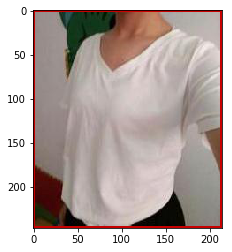

In [240]:
plt.imshow(img.transpose(1,2,0))

In [260]:
test_pairs[299]

[8613,
 ['./T_Shirt_all/id_00008613/comsumer_01.jpg',
  './T_Shirt_all/id_00008613/shop_01.jpg']]

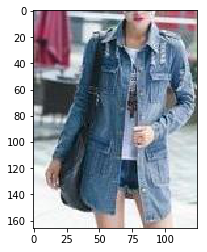

In [261]:
plt.imshow(Image.open(test_pairs[299][1][0]))

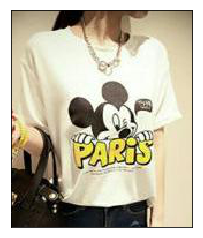

In [277]:
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    plt.tick_params(color='white')
plt.imshow(Image.open(test_pairs[5][1][0]))

In [274]:
import math
1-(math.factorial(1999)/(math.factorial(1999-20))*math.pow(1/2000.,20))

0.10000007489032958

In [279]:
20/len(test_pairs)

0.00984251968503937